In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import squidpy as sq

import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/osmfish"
figdir = "/data1/shahs3/users/mezallj1/figures/osmfish"

In [2]:
class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

In [3]:
class GAE(object):

    def __init__(self, adata, layers=[10,10], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None):
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold is not None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        edges = adata.obsp["spatial_connectivities"].nonzero()
        x = torch.from_numpy(adata.X).float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x, y] for x, y in zip(*edges)]
        if distance_scale is not None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0, distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1, 1)).reshape(1, -1)
            attrs = 1. / (np.array(attrs) ** exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=torch.from_numpy(attrs).to(self.device))
        self.adata = adata
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features, layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1], layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder, decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adadelta(self.gae.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0):
        prev_loss = 0.
        for i in range(epochs):
            self.optimizer.zero_grad()
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            reconstruction = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            loss = self.loss(reconstruction, self.data.x)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()
            if abs(curr_loss - prev_loss) < threshold:
                print("Minimum threshold!")
                break
            prev_loss = curr_loss
        print("Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu

In [4]:
adata = sc.read_h5ad(f'{datadir}/raw/osmfish_remove_excluded.h5ad')
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [5]:
sq.gr.spatial_neighbors(adata,radius=50,coord_type='generic',delaunay=True) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [6]:
gae = GAE(adata, layers=[50,50], lr=0.05)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [7]:
gae.train(1000, update_interval=1, threshold=1e-3)

Epoch 0 ** iteration 0 ** Loss: 146747.953125
Epoch 1 ** iteration 1 ** Loss: 142217.859375
Epoch 2 ** iteration 2 ** Loss: 138062.890625
Epoch 3 ** iteration 3 ** Loss: 134319.546875
Epoch 4 ** iteration 4 ** Loss: 131118.0625
Epoch 5 ** iteration 5 ** Loss: 128108.3046875
Epoch 6 ** iteration 6 ** Loss: 125462.140625
Epoch 7 ** iteration 7 ** Loss: 123115.3046875
Epoch 8 ** iteration 8 ** Loss: 120903.0390625
Epoch 9 ** iteration 9 ** Loss: 118987.8984375
Epoch 10 ** iteration 10 ** Loss: 117130.9921875
Epoch 11 ** iteration 11 ** Loss: 115511.7109375
Epoch 12 ** iteration 12 ** Loss: 113958.5859375
Epoch 13 ** iteration 13 ** Loss: 112570.5703125
Epoch 14 ** iteration 14 ** Loss: 111257.6484375
Epoch 15 ** iteration 15 ** Loss: 110059.1953125
Epoch 16 ** iteration 16 ** Loss: 108936.875
Epoch 17 ** iteration 17 ** Loss: 107905.6484375
Epoch 18 ** iteration 18 ** Loss: 106912.5703125
Epoch 19 ** iteration 19 ** Loss: 106029.0390625
Epoch 20 ** iteration 20 ** Loss: 105178.296875
Epoc

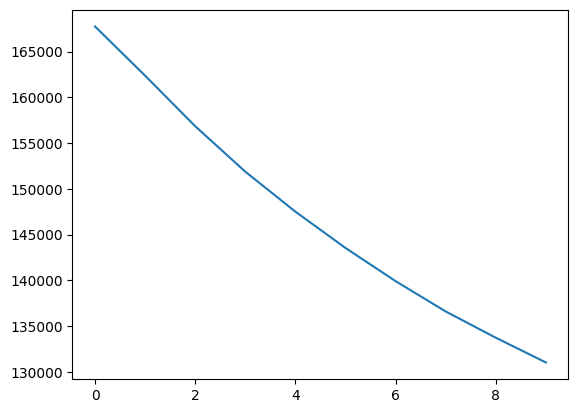

In [42]:
gae.plot()